In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline

In [2]:
df = pd.read_csv("../data/extracted_subset.csv")
print df.shape
print df.head()

(441456, 10)
   _MICHD  SEX  MARITAL  _RFBMI5  DIABETE3  _RFCHOL  EXERANY2  FRUIT1  \
0     2.0  2.0      1.0      2.0       3.0      2.0       2.0   310.0   
1     2.0  2.0      2.0      2.0       3.0      1.0       1.0   305.0   
2     NaN  2.0      2.0      1.0       3.0      2.0       NaN     NaN   
3     2.0  2.0      1.0      2.0       3.0      2.0       2.0   101.0   
4     2.0  2.0      1.0      1.0       3.0      1.0       2.0   102.0   

   _AGEG5YR  FVGREEN  
0       9.0    310.0  
1       7.0    202.0  
2      11.0      NaN  
3       9.0    301.0  
4       9.0    204.0  


In [3]:
df = df[df._MICHD >= 1]
df['HD'] = np.where(df['_MICHD']==1, 1, 0)
df = df[df._AGEG5YR < 14]
df = df[df._AGEG5YR >= 10]
df = df[df._RFCHOL > 0]
df = df[df.EXERANY2 > 0]
df = df[df.FRUIT1 >= 0]
df = df[df.FVGREEN >= 0]
print df.shape

(133690, 11)


In [15]:
def fruit2daily_fruit(row):
    if row['FRUIT1'] >= 100 and row['FRUIT1'] < 200:
        val = row['FRUIT1']-100
    elif row['FRUIT1'] >= 200 and row['FRUIT1'] < 300:
        val = (row['FRUIT1']-200)/7
    elif row['FRUIT1'] == 300:
        val = 0.02
    elif row['FRUIT1'] > 300 and row['FRUIT1']<400:
        val = (row['FRUIT1'] - 300)/30
    elif row['FRUIT1'] == 555:
        val = 0
    else: 
        val = float('NaN')
    return val

def fvgreen2daily_veggie(row):
    if row['FVGREEN'] >= 100 and row['FVGREEN'] < 200:
        val = row['FVGREEN']-100
    elif row['FVGREEN'] >= 200 and row['FVGREEN'] < 300:
        val = (row['FVGREEN']-200)/7
    elif row['FVGREEN'] == 300:
        val = 0.02
    elif row['FVGREEN'] > 300 and row['FVGREEN']<400:
        val = (row['FVGREEN'] - 300)/30
    elif row['FVGREEN'] == 555:
        val = 0
    else: 
        val = float('NaN')
    return val

The following section creates dailyFruit and dailyVeggie features. It takes a couple of minutes to run. So please be patient!!

In [16]:
df['dailyFruit'] = df.apply(fruit2daily_fruit,axis = 1) 
df['dailyVeggie'] = df.apply(fvgreen2daily_veggie,axis = 1)

In [17]:
df = df[df.dailyFruit >= 0]
df = df[df.dailyVeggie >= 0]
df = df[df.dailyFruit <= 3]
df = df[df.dailyVeggie <= 3]
df.shape

(127038, 13)

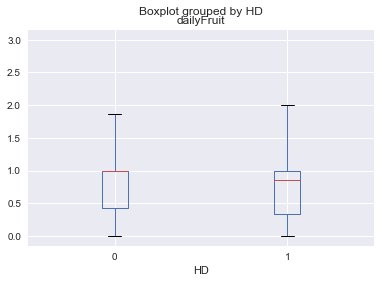

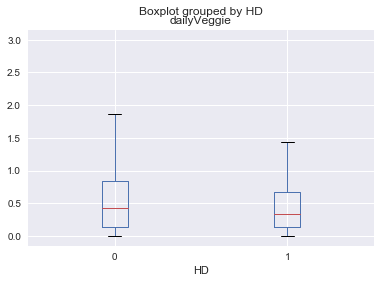

In [22]:
df.boxplot(column="dailyFruit", by="HD")
df.boxplot(column="dailyVeggie", by="HD")

In [24]:
df['single'] = np.where(df.MARITAL==1,0,np.where(df.MARITAL==6,0,1))
df['diabetic'] = np.where(df.DIABETE3==1,1,np.where(df.DIABETE3==2,1,0))
df['male'] = np.where(df.SEX == 1,1,0)
df['hicholesterol'] = np.where(df._RFCHOL == 2, 1, 0)
df['ow_obese'] = np.where(df._RFBMI5 == 2, 1, 0)
df['exercise'] = np.where(df.EXERANY2 == 1, 1, 0)

In [30]:
final_cols = ["HD","dailyFruit","dailyVeggie","exercise","single","ow_obese","hicholesterol","male","diabetic"]
df = df[final_cols]
df.shape

(127038, 9)

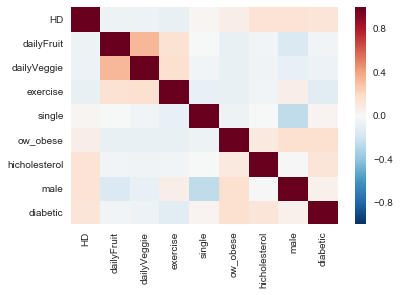

In [28]:
sns.heatmap(df.corr())

In [29]:
# Save subset of clean data to CSV
df.to_csv("../data/final_data_set.csv",index=False)

In [4]:
# Read dataset into dataframe
df = pd.read_csv("../data/final_data_set.csv")
print df.shape

(127038, 9)


In [5]:
# Initial analysis with Logistic Regression
feature_cols = ["dailyFruit","dailyVeggie"]
X = df[feature_cols]
y = df.HD
logReg = LogisticRegression()
print X.shape, y.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
logReg.fit(X_train,y_train)    
y_pred_class = logReg.predict(X_test)
print "Accuracy: ", metrics.accuracy_score(y_test, y_pred_class)
print "Recall: ", metrics.recall_score(y_test, y_pred_class)
print metrics.confusion_matrix(y_test, y_pred_class)

(127038, 2) (127038L,)
Accuracy:  0.829722921914
Recall:  0.0
[[26352     0]
 [ 5408     0]]


In [6]:
# Initial analysis with KNN
feature_cols = ["dailyFruit","dailyVeggie"]
X = df[feature_cols]
y = df.HD
print X.shape, y.shape
knn = KNeighborsClassifier(n_neighbors= 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
knn.fit(X_train,y_train)    
y_pred_class = knn.predict(X_test)
print "Accuracy: ", metrics.accuracy_score(y_test, y_pred_class)
print "Recall: ", metrics.recall_score(y_test, y_pred_class)
print metrics.confusion_matrix(y_test, y_pred_class)

(127038, 2) (127038L,)
Accuracy:  0.750409319899
Recall:  0.133136094675
[[23113  3239]
 [ 4688   720]]


In [7]:
#Undersampling the data
df_original = df
print "# records before under sampling: ", df.shape
sample_size = sum(df_original.HD == 1)
HD_indices = df_original[df_original.HD == 1].index
nonHD_indices = df_original[df_original.HD == 0].index
random_indices = np.random.choice(nonHD_indices, sample_size, replace=False)
df = df_original.loc[random_indices]
df = df.append(df_original.loc[HD_indices])
print "# records after under sampling: ", df.shape

# records before under sampling:  (127038, 9)
# records after under sampling:  (43528, 9)


In [83]:
# Analysis with KNN on Under sampled data
feature_cols = ["dailyFruit","dailyVeggie"]
X = df[feature_cols]
y = df.HD
#print X.shape, y.shape
scores_df = pd.DataFrame(columns = ("neighbors","metric"))

for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors= i)
    scores = cross_val_score(knn, X, y, cv=10, scoring='f1')
    scores_df.loc[i] = [i,scores.mean()]
#print scores_df
print scores_df.loc[scores_df['metric'].idxmax()]

neighbors    1.000000
metric       0.471976
Name: 1, dtype: float64


In [84]:
# Try predicting using train test split
knn = KNeighborsClassifier(n_neighbors= 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)
knn.fit(X_train,y_train)    
y_pred_class = knn.predict(X_test)
#print metrics.accuracy_score(y_test, y_pred_class)

print metrics.f1_score(y_test, y_pred_class)

print metrics.confusion_matrix(y_test, y_pred_class)

0.531266149871
[[2356 2998]
 [2444 3084]]


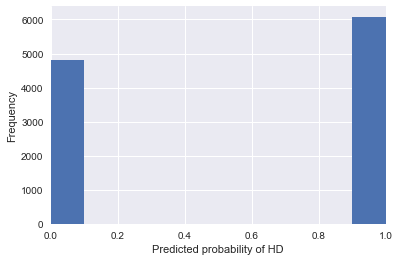

In [85]:
y_pred_prob = knn.predict_proba(X_test)[:, 1]
plt.hist(y_pred_prob)
plt.xlim(0, 1)
plt.xlabel('Predicted probability of HD')
plt.ylabel('Frequency')

In [68]:
# Analysis with KNN on Under sampled data with dailyFruit only
feature_cols = ["dailyFruit"]
X = df[feature_cols]
y = df.HD
#print X.shape, y.shape
scores_df = pd.DataFrame(columns = ("neighbors","metric"))

for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors= i)
    scores = cross_val_score(knn, X, y, cv=10, scoring='f1')
    scores_df.loc[i] = [i,scores.mean()]
#print scores_df
print scores_df.loc[scores_df['metric'].idxmax()]

neighbors    1.000000
metric       0.386601
Name: 1, dtype: float64


In [22]:
# Analysis with KNN on under sampled data
feature_cols = ["dailyFruit","dailyVeggie","exercise","diabetic","hicholesterol"]
X = df[feature_cols]
y = df.HD
#print X.shape, y.shape
scores_df = pd.DataFrame(columns = ("neighbors","metric"))

for i in range(1,50):
    knn = KNeighborsClassifier(n_neighbors= i)
    scores = cross_val_score(knn, X, y, cv=10, scoring='f1')
    scores_df.loc[i] = [i,scores.mean()]
#print scores_df
print scores_df.loc[scores_df['metric'].idxmax()]

C:\Users\rrambhia\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


neighbors    1.000000
metric       0.255471
Name: 1, dtype: float64


In [25]:
# Analysis with KNN on under sampled data with accuracy
feature_cols = ["dailyFruit","dailyVeggie","exercise","diabetic","hicholesterol"]
X = df[feature_cols]
y = df.HD
#print X.shape, y.shape
scores_df = pd.DataFrame(columns = ("neighbors","metric"))

for i in range(1,50):
    knn = KNeighborsClassifier(n_neighbors= i)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    scores_df.loc[i] = [i,scores.mean()]
#print scores_df
print scores_df.loc[scores_df['metric'].idxmax()]

neighbors    5.000000
metric       0.523938
Name: 5, dtype: float64


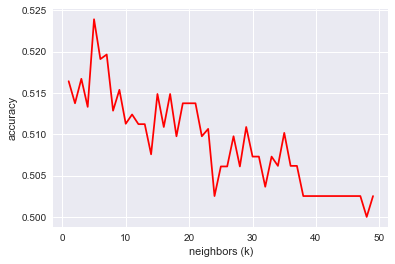

In [26]:
plt.plot(scores_df.neighbors, scores_df.metric, color='red')
plt.xlabel('neighbors (k)')
plt.ylabel('accuracy')

In [28]:
# Try predicting using train test split
feature_cols = ["dailyFruit","dailyVeggie","exercise","diabetic","hicholesterol"]
X = df[feature_cols]
y = df.HD
knn = KNeighborsClassifier(n_neighbors= 50)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)
knn.fit(X_train,y_train)    
y_pred_class = knn.predict(X_test)
#print metrics.accuracy_score(y_test, y_pred_class)
print metrics.f1_score(y_test, y_pred_class)
print metrics.accuracy_score(y_test, y_pred_class)
print metrics.confusion_matrix(y_test, y_pred_class)

0.60447761194
0.600624885131
[[3215 2139]
 [2207 3321]]


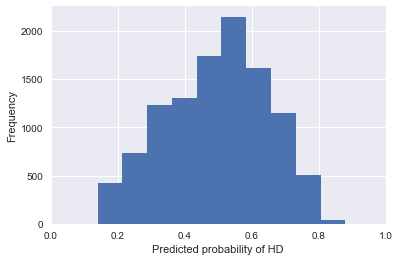

In [29]:
y_pred_prob = knn.predict_proba(X_test)[:, 1]
plt.hist(y_pred_prob)
plt.xlim(0, 1)
plt.xlabel('Predicted probability of HD')
plt.ylabel('Frequency')